In [1]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")
import numpy as np
import matplotlib.pyplot as plt

import torch
from ase import Atoms
import matplotlib

matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams["legend.fancybox"] = False

In [2]:
## define models 

In [3]:
from scripts.forceconv.forceconv import *
from scripts.forceconv.forcepai import ForcePai_polar, ForcePai
from scripts import forceconv 
DEVICE ='cpu'
trainparam = {
  "cutoff": 5.0,
  "n_atom_basis": 128,
  "n_convolutions": 4,
  "n_edge_basis": 256,
  "n_filters": 256,
  "n_gaussians": 32
}

model = ForceConvolve(n_convolutions=trainparam['n_convolutions'], 
                      n_edge_basis=trainparam['n_edge_basis'], 
                      n_atom_basis=trainparam['n_atom_basis'], 
                      n_filters=trainparam['n_filters'], 
                      n_gaussians=trainparam['n_gaussians'], 
                      cutoff=trainparam['cutoff'],
                      edge_filter_depth=1,
                      atom_filter_depth=1,
                      edge_update_depth=1,
                      atom_update_depth=1
                     ).to(DEVICE)
    

# modelparms = {'feat_dim': 64, 'n_rbf': 8, 'cutoff':5.0, 'num_conv': 3}
# model = ForcePai(modelparms)


In [14]:
from scripts.forceconv.MD17data import *
ethanol_data = get_MD17data('ethanol_dft')
#ethanol_data = pack_MD17data(ethanol_data, 2000)


def get_batch(xyz, cutoff=6.0):
    '''transform xyz into a databach'''
    
    xyz = torch.Tensor(xyz)
    n = xyz.size(0)
    dist = (xyz.expand(n, n, 3) - xyz.expand(n, n, 3).transpose(0, 1)
            ).pow(2).sum(dim=2).sqrt()

    # neighbor list
    mask = (dist <= cutoff)
    mask[np.diag_indices(n)] = 0
    nbr_list = mask.nonzero()

    nxyz = torch.Tensor( np.hstack( (ethanol_data.f.z[:, None] , xyz)))

    return {'nxyz': nxyz, 'nbr_list': nbr_list}

In [15]:
# generate data points for the loop integrals 

In [22]:
atoms = Atoms(positions=ethanol_data.f.R[-1], numbers=ethanol_data.f.z)

coord_list = [] # list of coordinates 
dihe_list = []
atoms_list = []  # list of dihedral angles 

# Rotate the CCOH diheral angle for 360 degress.
n_rot = 200 # we sample 200 points along the path 
for i in range(n_rot ):
    atoms.rotate_dihedral(1, 0, 2, 8, 360.0/n_rot, indices=[8] )
    positions = atoms.get_positions()      
    coord_list.append(positions)
    dihe_list.append( atoms.get_dihedral(1, 0, 2, 8) )
    atoms_list.append(Atoms(positions=positions, numbers=ethanol_data.f.z))

In [23]:
# compute forces 
f_list = [] # list forces 
for i, xyz in enumerate( coord_list[:-1]) :
    
    dr = coord_list[i + 1] - xyz # compute dr 
     
    batch = get_batch(xyz + 0.5 * dr) # compute force at mid-point 
    f = -model(batch)['energy_grad']

    dr = torch.Tensor(dr)
    f_list.append((f * dr).sum().detach().numpy()) # dot product 

In [24]:
# Integrate forces 
integral = []
for i in range(len(dihe_list[:-1])):
    integral.append(np.array(f_list[:i]).sum() )

In [25]:
# Get energy offset 
deg_0_index = np.array(dihe_list).argmin()
offset = integral[deg_0_index]

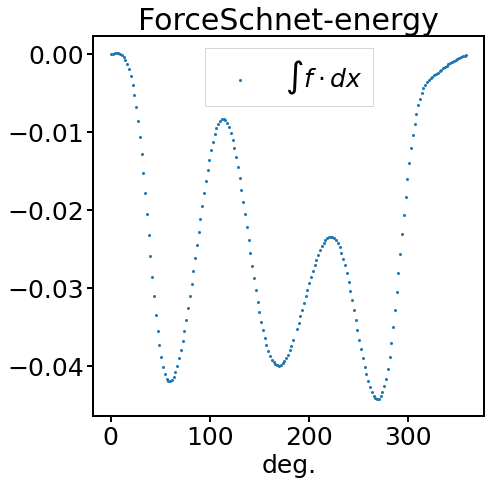

In [26]:
plt.figure(figsize=(7,7))

plt.title("ForceSchnet-energy")
# plt.plot([0.0, 360.0], [0.0, 0.0], linestyle='--', color='g')
plt.scatter(dihe_list[:-1], np.array(integral) - offset, label=r'$ \int f \cdot dx$', s= 4)

plt.legend()
plt.xlabel("deg.")
plt.show()

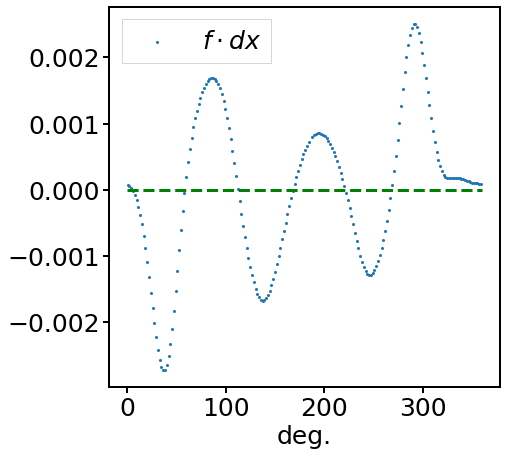

In [27]:
plt.figure(figsize=(7,7))

plt.plot([0.0, 360.0], [0.0, 0.0], linestyle='--', color='g')
plt.scatter(dihe_list[:-1], f_list, label=r'$f \cdot dx$', s= 4)


plt.legend()
plt.xlabel("deg.")
plt.show()